## Figuring what Convolution networks See. 

We all have since fancy pictures of output of each layers and how CNN's work on them. Now we will see it on VGG

##### Boring Stuff first, please ignore

In [12]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16
import collections
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
import numpy.ma as ma
import pylab as pl
import matplotlib.cm as cm
import theano as theano

from mpl_toolkits.axes_grid1 import make_axes_locatable
def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    print(mosaic.shape)
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        #print (i)
        #print ("row",row * paddedh, row * paddedh + imshape[0])
        #print ("col",col * paddedw, col * paddedw + imshape[1])
        #if i==36:
        #   print (imgs[i])
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

#### Problem statement
We are trying to solve the Kaggle Problem for classifying Dogs and Cats . The problem can be found [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). We will use the vgg Model . And use the helper class vgg that you can find within the repo. We do not want to waste time training the model. If you want to know more about how I have solved it. Please visit the lesson 1 . 

In [3]:
vgg = Vgg16()
vgg.model.load_weights('kaggle_dogs_cats_redux.h5')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


To see the what the model is doing , have a look at the summary. I prefer it more than than the config view since it is readable.

In [4]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
#if you want to go into the details of all the layers use
#vgg.model.get_config()

Lets delve deeper into the one of the layers

We are interested in the first convolution layer . So we will see its config, parameters and biases

In [8]:
vgg.model.layers[2].get_config()

{'W_constraint': None,
 'W_regularizer': None,
 'activation': 'relu',
 'activity_regularizer': None,
 'b_constraint': None,
 'b_regularizer': None,
 'bias': True,
 'border_mode': 'valid',
 'dim_ordering': 'th',
 'init': 'glorot_uniform',
 'name': 'convolution2d_1',
 'nb_col': 3,
 'nb_filter': 64,
 'nb_row': 3,
 'subsample': (1, 1),
 'trainable': True}

In [9]:
vgg.model.layers[2].count_params()

1792

So we got the count of params. And we can now see the individual weights.

In [10]:
vgg.model.layers[2].W.get_value().shape

(64, 3, 3, 3)

Lets see the biases now

In [11]:
vgg.model.layers[2].b.get_value().shape

(64,)

So if we add up (64*3*3*3) + 64 = 1792 ( The total parameters ). Lets look at the 64 filters in the first convolution layer which comes at position 3.

But before that lets write a small utility function that we will use

In [39]:
def displayFilters(layerData, title):
    W = layerData.W.get_value(borrow=True)
    W = np.squeeze(W)
    print("W shape of layer : ", W.shape)
    singleChannelW = W[:,:,:,0]
    singleChannelW = np.squeeze(singleChannelW)
    print("singleChannelW shape : ", singleChannelW.shape)
    pl.figure(figsize=(15, 15))
    pl.title(title)
    nice_imshow(pl.gca(), make_mosaic(singleChannelW, 8, 8), cmap=cm.binary)

In [23]:
#### First lets visualize the input image 

Found 2388 images belonging to 2 classes.
(1, 3, 224, 224)


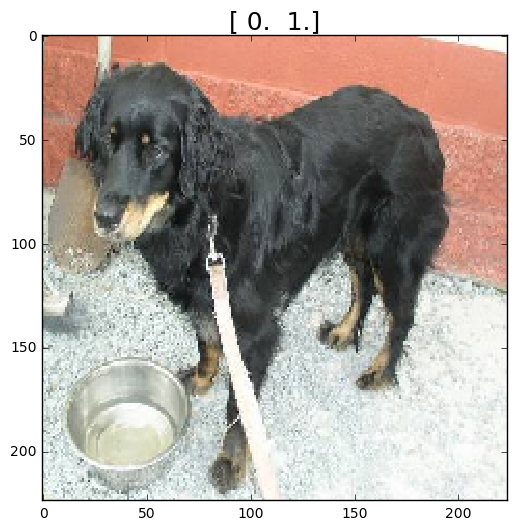

In [29]:
path = "../data/kaggle/output/sample/"
batches = vgg.get_batches(path+'train', batch_size=1)
imgs,labels = next(batches)
print(imgs.shape)
plots(imgs, titles=labels)

(224, 224)


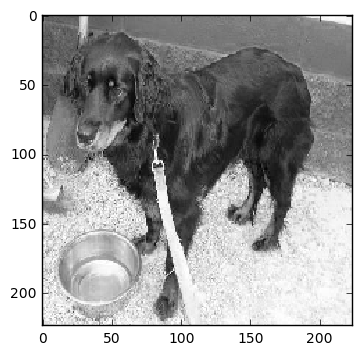

In [33]:
img = imgs[0]
print(img[2].shape)
#selecting only one channel
plt.gray()
plt.imshow(img[2].astype(np.float32), interpolation='nearest')
input_image = img.astype(np.float32)

In [34]:
#### Display the filters which will convolve the image

W shape of layer :  (64, 3, 3, 3)
singleChannelW shape :  (64, 3, 3)
(31, 31)


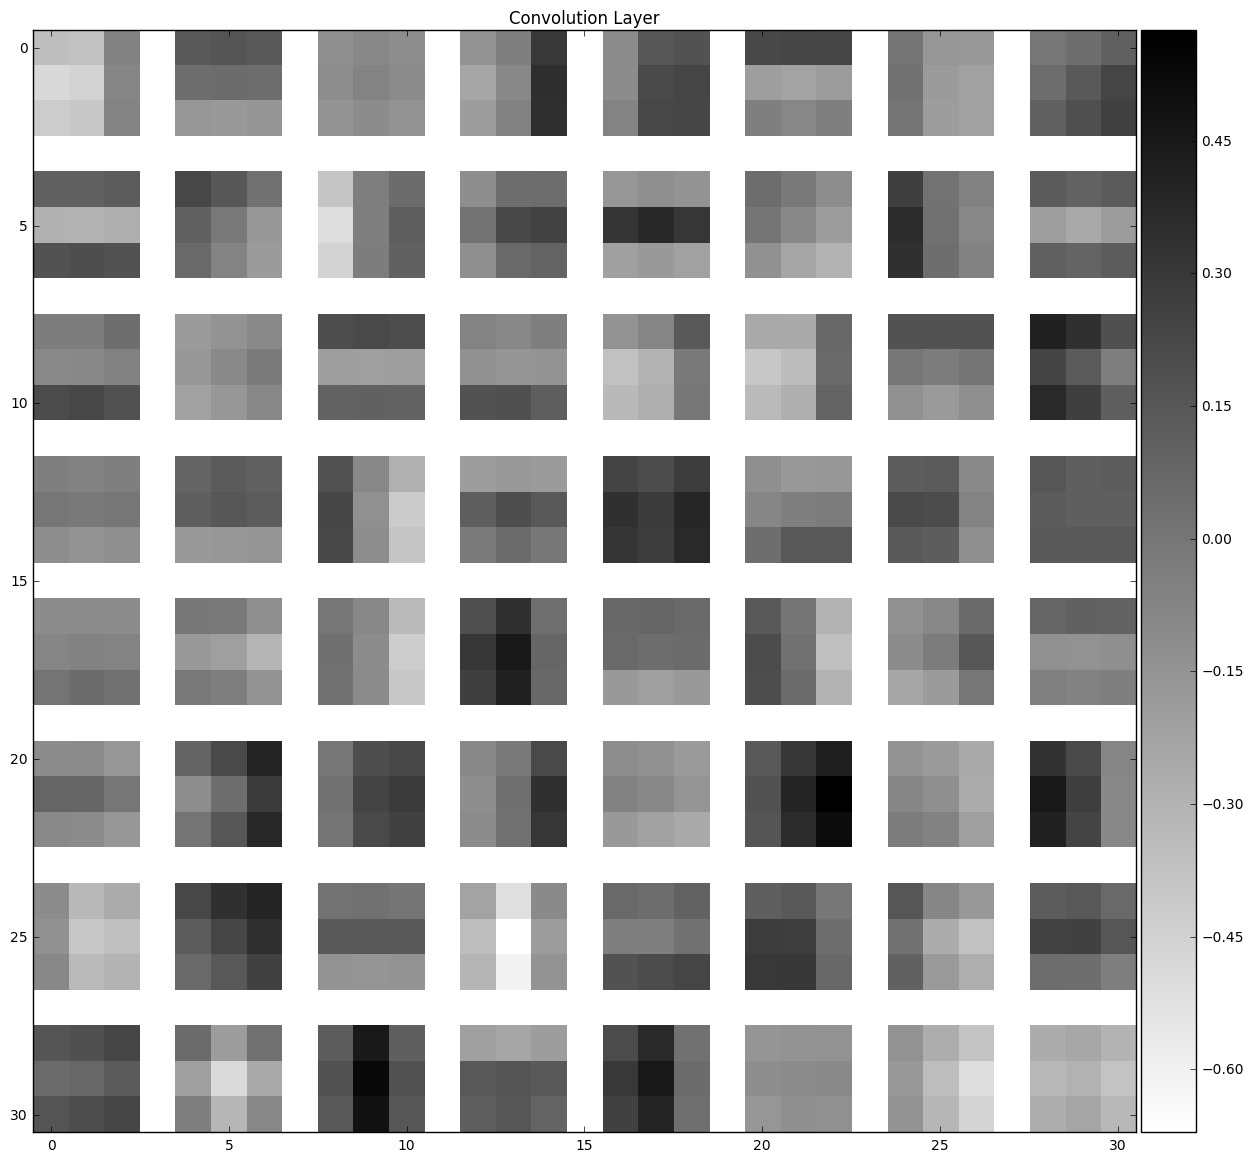

In [40]:
displayFilters(vgg.model.layers[2], "Convolution Layer")

#### Now lets visualize the output layer 


(1, 64, 224, 224)


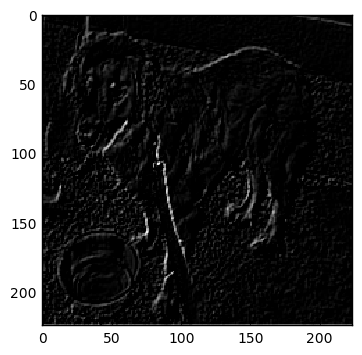

In [36]:
output_layer = vgg.model.layers[2].output
output_fn = theano.function([vgg.model.layers[0].input], output_layer)
input_image.shape = (1, 3, 224, 224)
output_image = output_fn(input_image)
print(output_image.shape)
plt.imshow(output_image[0,0,:,:], interpolation='nearest')

##### The image above shows 1 of the 64 image generated by 64 filters. So we see how the input images has changed across 3 layers

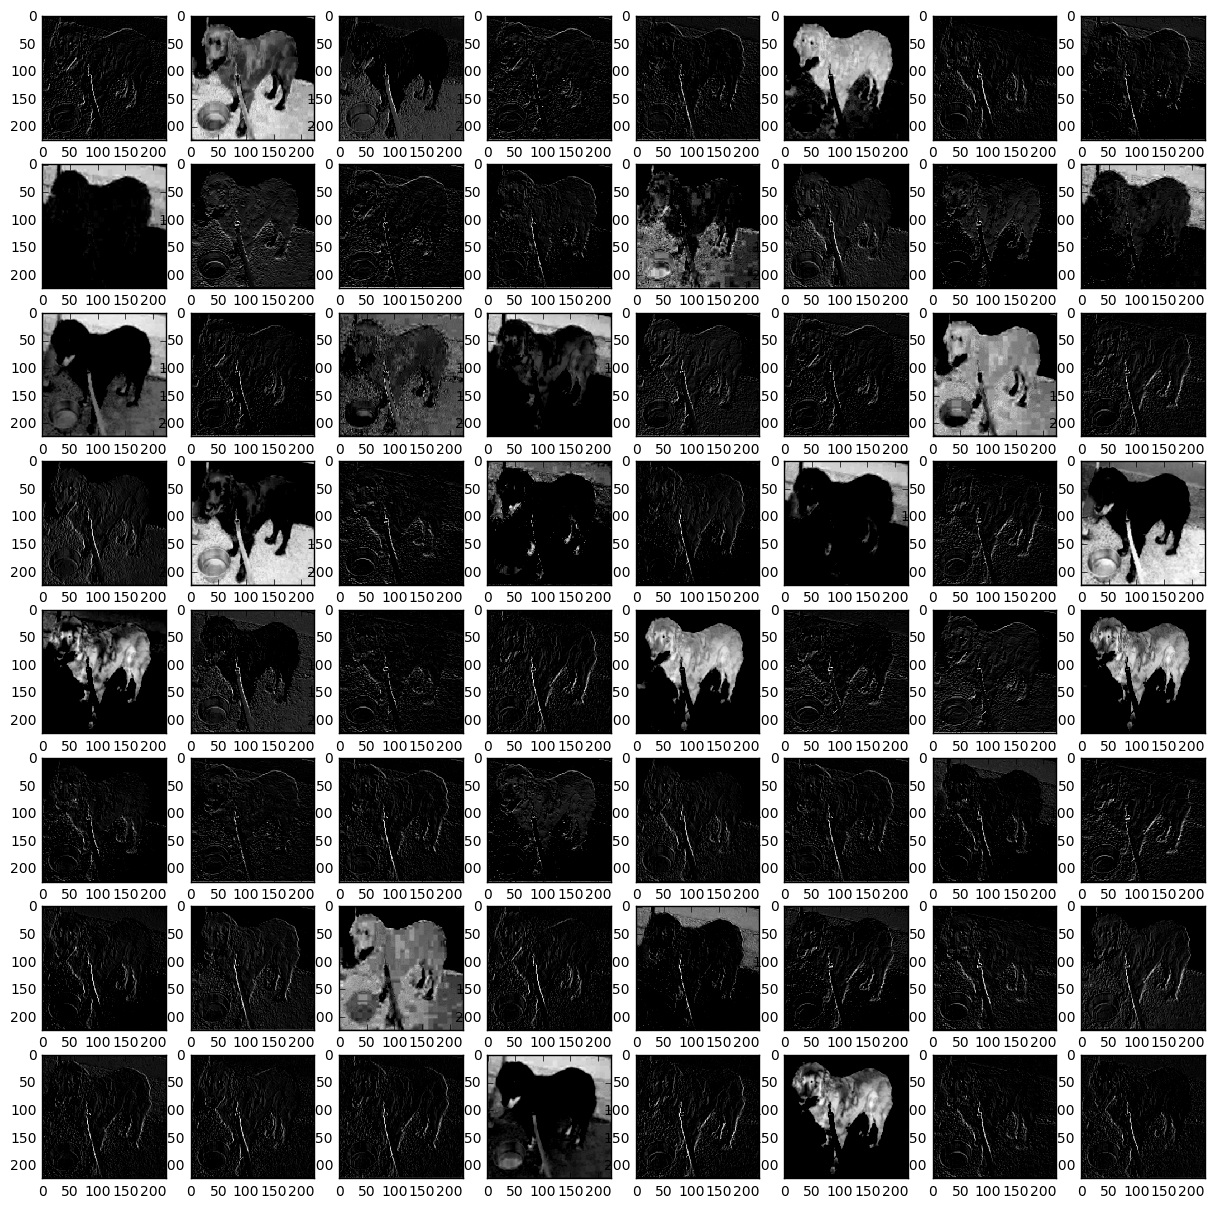

In [38]:
f=plt.figure(figsize=(15, 15))
for i in range(64):
    sub = f.add_subplot(8, 8, i + 1 )
    sub.imshow(output_image[0,i,:,:], interpolation='nearest')

### If you match these with the above filters , you will see how the edge detecting kernels have affected the image

#### Lets look at what happens when the images reach the second convolution layer which is layer 4

convolution2d_2 (Convolution2D)  (None, 64, 224, 224)  36928       zeropadding2d_2[0][0]            
_____________________________________________________________________________________________

(1, 64, 224, 224)


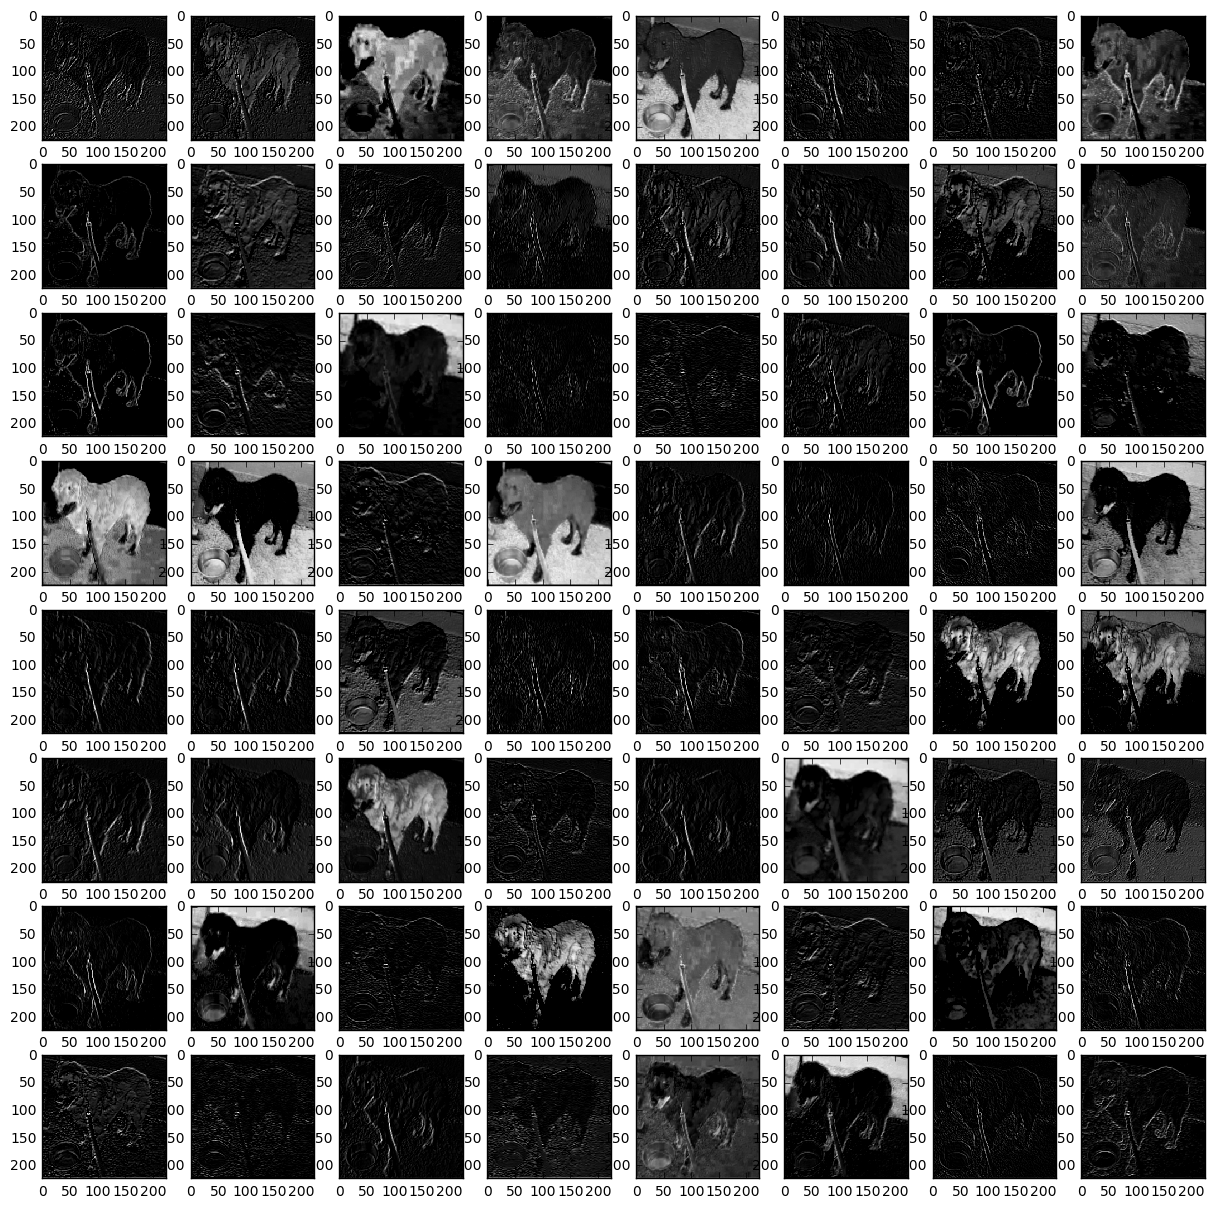

In [45]:
output_layer = vgg.model.layers[4].output
output_fn = theano.function([vgg.model.layers[0].input], output_layer)
input_image.shape = (1, 3, 224, 224)
output_image = output_fn(input_image)
print(output_image.shape)
f=plt.figure(figsize=(15, 15))
for i in range(64):
    sub = f.add_subplot(8, 8, i + 1 )
    sub.imshow(output_image[0,i,:,:], interpolation='nearest')

### Now lets look at the next 3 filters. Interestingly the number of images increases and the sizes reduce

In [ ]:
maxpooling2d_1 (MaxPooling2D)    (None, 64, 112, 112)  0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
zeropadding2d_3 (ZeroPadding2D)  (None, 64, 114, 114)  0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 128, 112, 112) 73856       zeropadding2d_3[0][0] 

(1, 128, 112, 112)


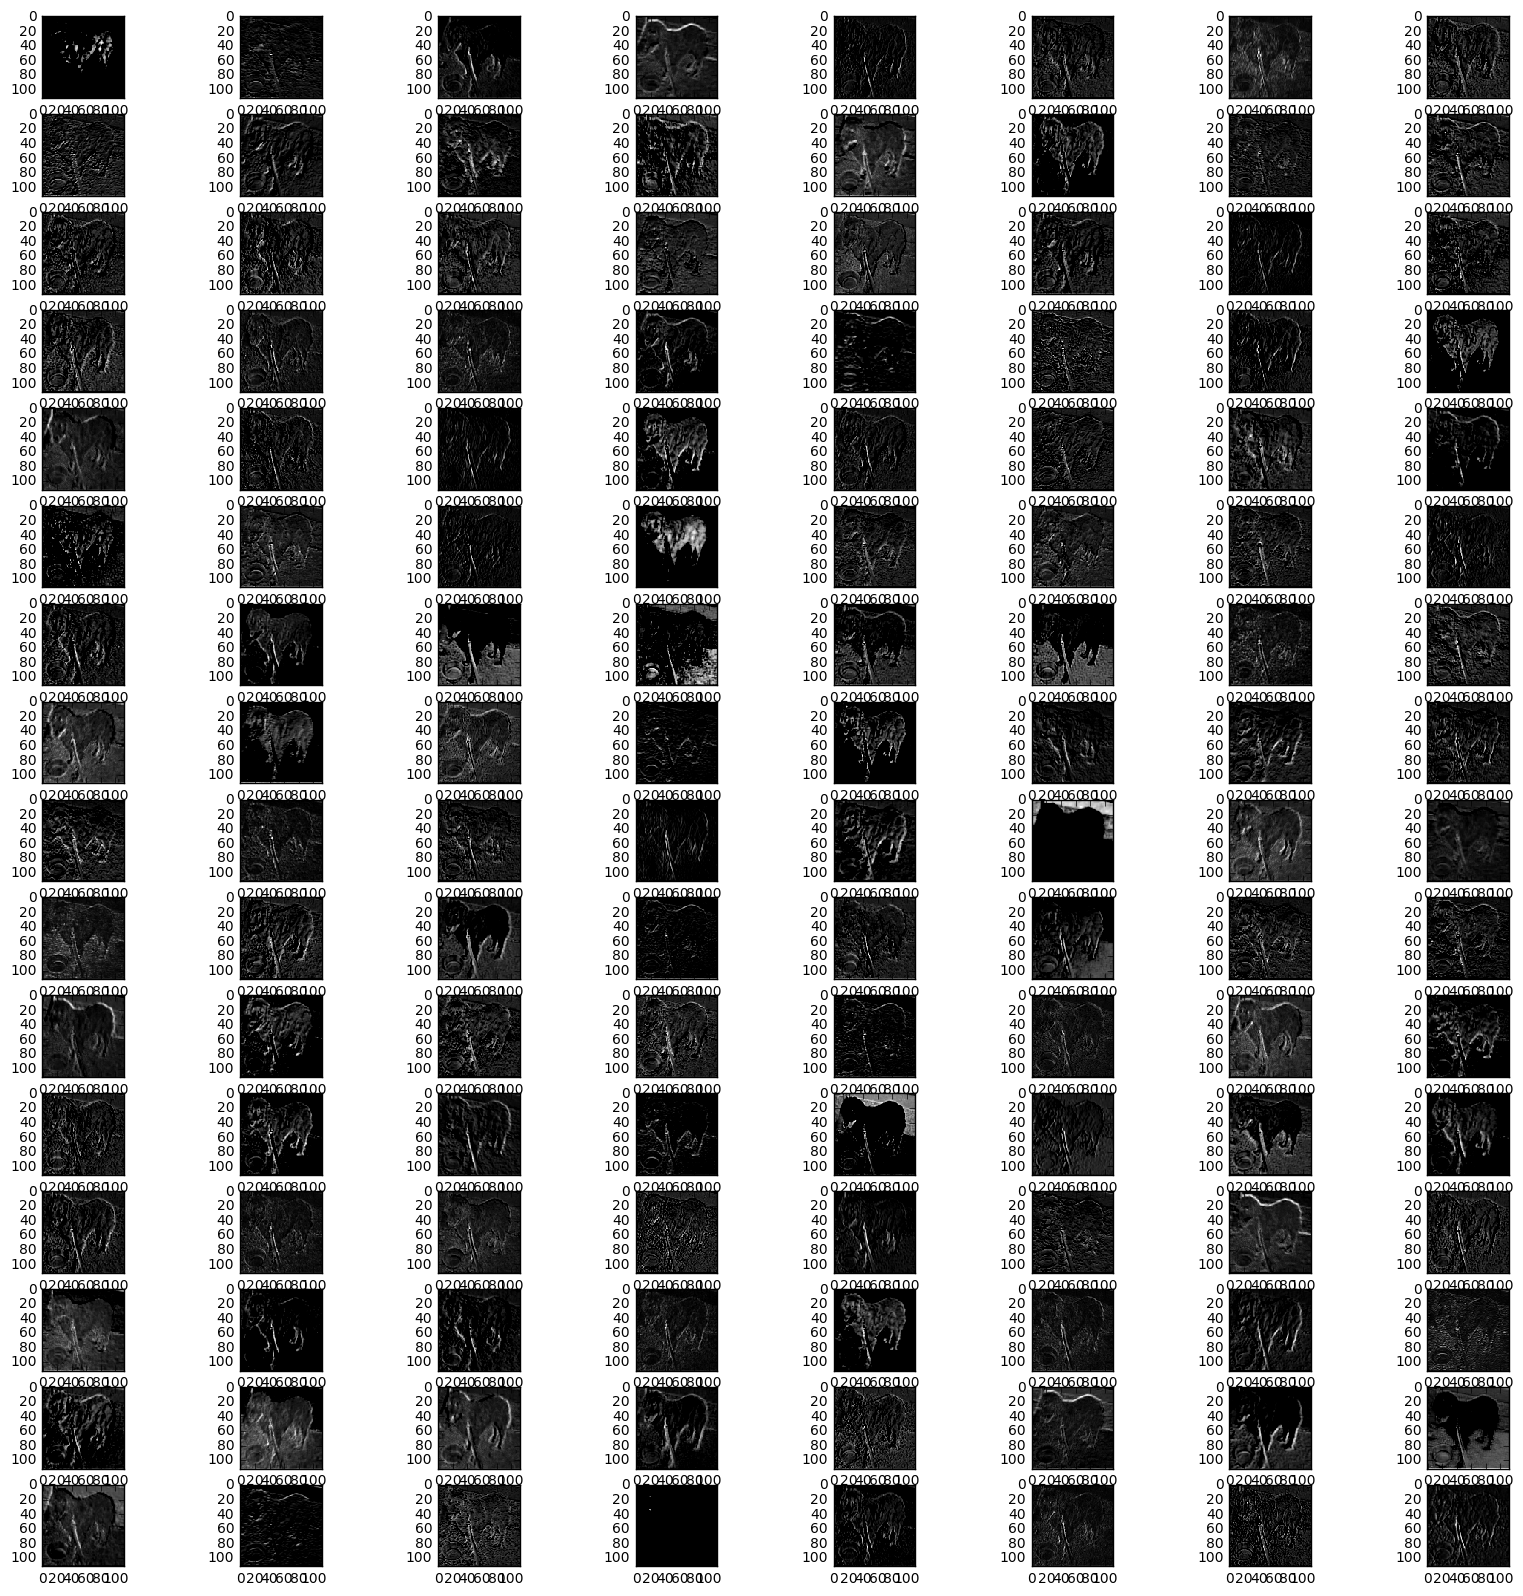

In [50]:
output_layer = vgg.model.layers[7].output
output_fn = theano.function([vgg.model.layers[0].input], output_layer)
input_image.shape = (1, 3, 224, 224)
output_image = output_fn(input_image)
print(output_image.shape)
f=plt.figure(figsize=(20, 20))
for i in range(128):
    sub = f.add_subplot(16, 8, i + 1 )
    sub.imshow(output_image[0,i,:,:], interpolation='nearest')

In [55]:
vgg.model.layers[19].get_config()

{'W_constraint': None,
 'W_regularizer': None,
 'activation': 'relu',
 'activity_regularizer': None,
 'b_constraint': None,
 'b_regularizer': None,
 'bias': True,
 'border_mode': 'valid',
 'dim_ordering': 'th',
 'init': 'glorot_uniform',
 'name': 'convolution2d_8',
 'nb_col': 3,
 'nb_filter': 512,
 'nb_row': 3,
 'subsample': (1, 1),
 'trainable': True}

(1, 512, 28, 28)


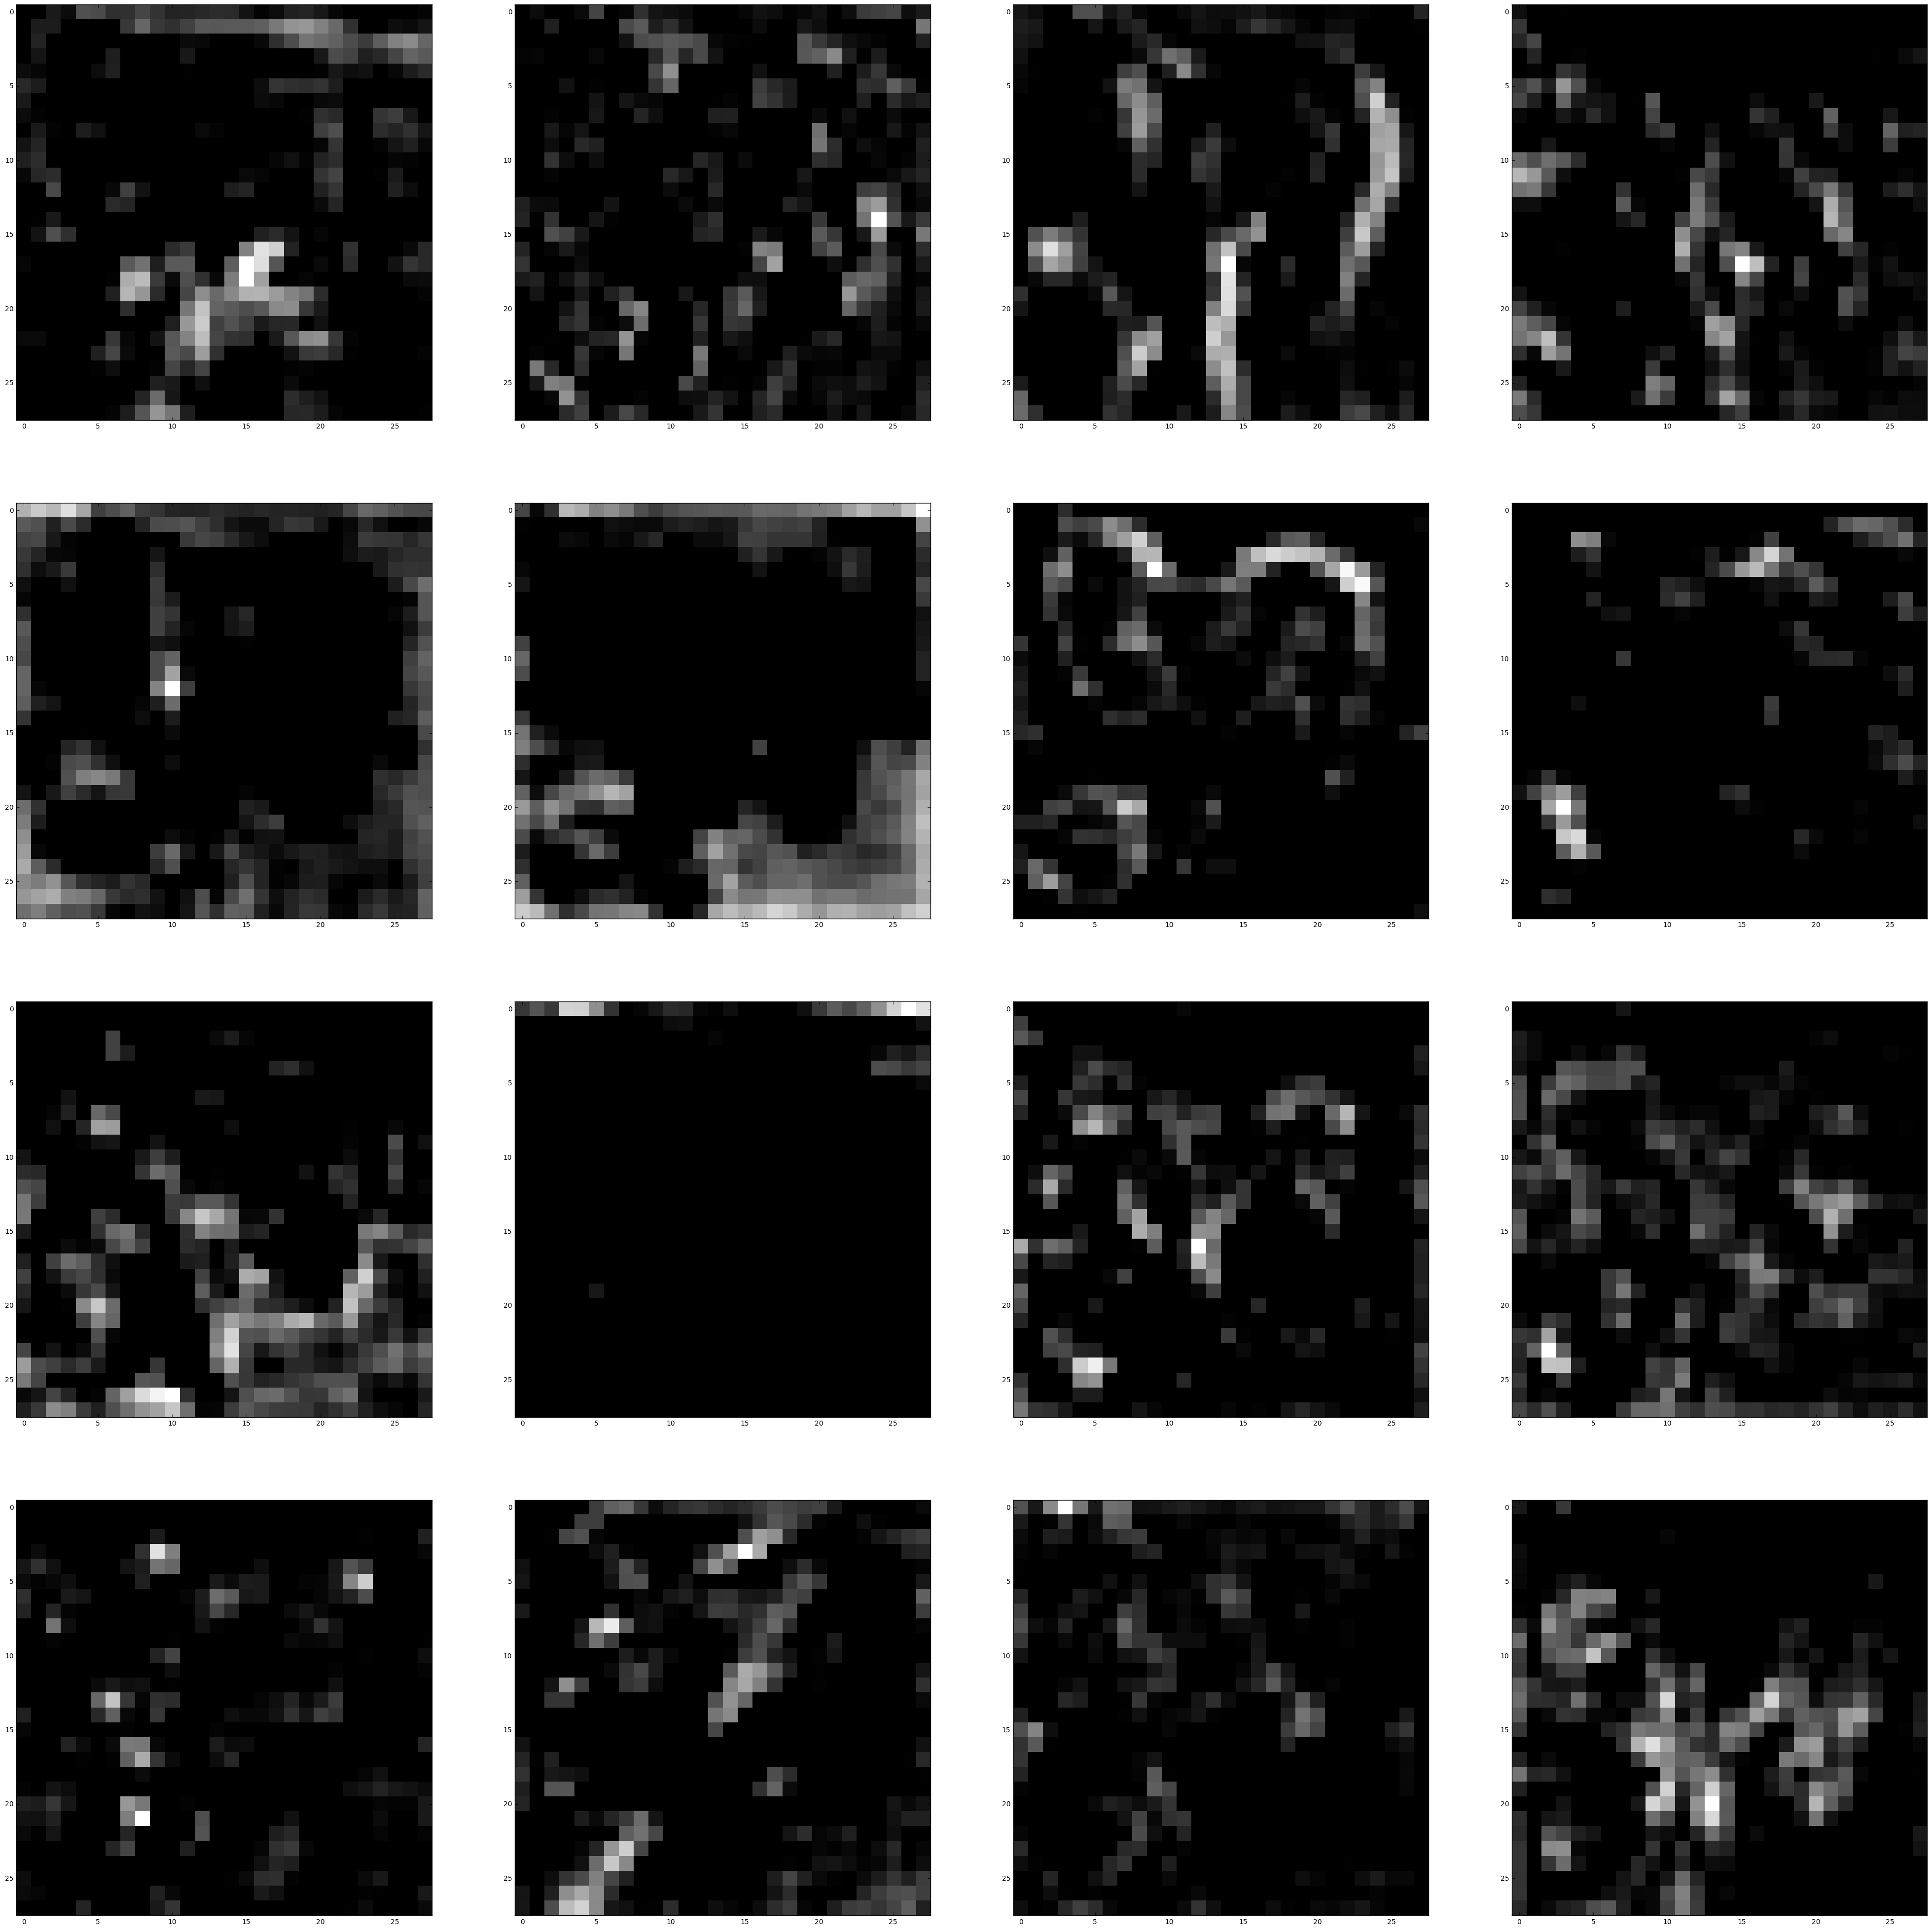

In [59]:
output_layer = vgg.model.layers[19].output
output_fn = theano.function([vgg.model.layers[0].input], output_layer)
input_image.shape = (1, 3, 224, 224)
output_image = output_fn(input_image)
print(output_image.shape)
f=plt.figure(figsize=(50, 50))
for i in range(16):
    sub = f.add_subplot(4, 4, i + 1 )
    sub.imshow(output_image[0,i,:,:], interpolation='nearest')

Well I do want to find images maximally activating the first 10 feature maps of this layer > need help in doing that :)